In [1]:
#%matplotlib widget
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import pack_vis
import pack_dimer
import pack_vis_sol
import pack_cost
import pack_dynamics
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
import copy
kgs.set_float32(False)

local


In [2]:
def canonicize(sol):
    # Enforce angle <= 90 degrees
    mask = sol.h[:, 2] > np.pi/2
    if cp.any(mask):
        sol.h[mask, 2] = np.pi - sol.h[mask, 2]
        sol.xyt[mask, :, 0] = -sol.xyt[mask, :, 0]
        sol.xyt[mask, :, 2] = -sol.xyt[mask, :, 2]

    sol.xyt[:,:,0] -= sol.xyt[:,0:1,0]
    sol.xyt[:,:,1] -= sol.xyt[:,0:1,1]

    # # shift tree 2 by the crystal axes such that it is just to the top right of tree 0
    # crystal_axes = sol.get_crystal_axes_allocate()
    # vec_a = crystal_axes[:,0,:2]
    # vec_b = crystal_axes[:,1,:2]
    # det = vec_a[:,0]*vec_b[:,1] - vec_a[:,1]*vec_b[:,0]
    # if cp.any(cp.abs(det) <= 1e-9):
    #     raise ValueError("Degenerate crystal axes detected")
    # pos_tree1 = sol.xyt[:,1,:2]
    # coeff_a = (vec_b[:,1]*pos_tree1[:,0] - vec_b[:,0]*pos_tree1[:,1]) / det
    # coeff_b = (-vec_a[:,1]*pos_tree1[:,0] + vec_a[:,0]*pos_tree1[:,1]) / det
    # coeff_a = cp.mod(coeff_a, 1.0)
    # coeff_b = cp.mod(coeff_b, 1.0)
    # pos_aligned = coeff_a[:,None]*vec_a + coeff_b[:,None]*vec_b
    # sol.xyt[:,1,:2] = pos_aligned

def find_optimal_tesselation(aspect_ratio, angle_degrees, N=20000, max_N =80000, check_val=10, show_plots=False):
    sol = kgs.SolutionCollectionLatticeFixed()
    sol.periodic = True
    sol.aspect_ratios = cp.array([aspect_ratio]*N, dtype=kgs.dtype_cp)
    sol.angles = cp.array([np.radians(angle_degrees)]*N, dtype=kgs.dtype_cp)
    sol = sol.create_empty(N, 2)
    sol.xyt[:,0,:2] = 0.
    generator = cp.random.default_rng(seed=42)
    sol.xyt[:,:,2] = generator.uniform(-np.pi/2, np.pi/2, size=(N,2), dtype=kgs.dtype_cp) # try to have tree 1 upright
    sol.xyt[:,1,2] = sol.xyt[:,0,2] + np.pi
    sol.xyt[:,1,:2] = generator.uniform(0, 2, size=(N,2), dtype=kgs.dtype_cp)
    sol.N_periodic = 4

    sol.h[:,0] = 1.
    sol.snap()

    sol_orig = copy.deepcopy(sol)    

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.n_iterations *= 1
    sol = optimizer.run_simulation(sol)

    canonicize(sol)
    

    cost_vals = optimizer.cost.compute_cost_allocate(sol)[0].get()
    #plt.figure()
    #plt.semilogy(np.sort(cost_vals))

    inds = np.argsort(cost_vals)

    if not cost_vals[inds[check_val]]<=1.001*cost_vals[inds[0]] and 2*N<=max_N:
        #print('trying higher N')
        s = find_optimal_tesselation(aspect_ratio, angle_degrees, N=2*N)
        #print('ok now')
        return s
    
    
    sol.select_ids(inds[:1])
    sol_orig.select_ids(inds[:1])

    sol2 = kgs.SolutionCollectionLattice()
    sol2.periodic = True
    sol2.xyt = copy.deepcopy(sol.xyt)
    sol2.h = cp.zeros((sol.N_solutions, 3), dtype=kgs.dtype_cp)
    sol2.h[:,0] = sol.h[:,0]
    sol2.h[:,1] = sol.h[:,0] * sol.aspect_ratios        
    sol2.h[:,2] = sol._get_angles()

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-2
    #optimizer.dt*=10
    optimizer.n_iterations *= 3
    optimizer.track_cost = show_plots
    optimizer.plot_cost = show_plots
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    sol2 = optimizer.run_simulation(sol2)

    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-3
    #optimizer.dt*=10
    optimizer.n_iterations *= 3
    optimizer.track_cost = show_plots
    optimizer.plot_cost = show_plots
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    sol2 = optimizer.run_simulation(sol2)
    canonicize(sol2)
    return sol, sol2, sol_orig

In [3]:
from tqdm.notebook import tqdm
aspect_ratios = np.linspace(0.35,0.65,31)
angles = np.linspace(30,90,61)
# sol_grid = [[None for _ in range(len(angles))] for _ in range(len(aspect_ratios))]
# sol_opt_grid = [[None for _ in range(len(angles))] for _ in range(len(aspect_ratios))]
# for ia, aspect_ratio in enumerate(tqdm(aspect_ratios, desc="Computing")):
#     for ib, angle in enumerate(tqdm(angles, desc="Angles", leave=False)):
#         sol, sol_opt, _ = find_optimal_tesselation(aspect_ratio, angle)
#         sol_grid[ia][ib] = sol
#         sol_opt_grid[ia][ib] = sol_opt
# kgs.dill_save(kgs.code_dir + '/../res/packings2.pickle', (sol_grid, sol_opt_grid))
sol_grid, sol_opt_grid, _, _ = kgs.dill_load(kgs.code_dir + '/../res/packings2.pickle')





In [4]:
res1 = np.zeros((len(aspect_ratios), len(angles)))
res2 = np.zeros((len(aspect_ratios), len(angles)))
res3 = np.zeros((len(aspect_ratios), len(angles)))
res4 = np.zeros((len(aspect_ratios), len(angles)))
res_aspect_ratios = np.zeros((len(aspect_ratios), len(angles)))
res_angles = np.zeros((len(aspect_ratios), len(angles)))

for ia, aspect_ratio in enumerate(tqdm(aspect_ratios, desc="Recalculating")):
    for ib, angle in enumerate(angles):
        sol, sol_opt = sol_grid[ia][ib], sol_opt_grid[ia][ib]
        sol.xyt = sol.xyt.astype(kgs.dtype_cp)
        sol_opt.xyt = sol_opt.xyt.astype(kgs.dtype_cp)
        sol.h = sol.h.astype(kgs.dtype_cp)
        sol_opt.h = sol_opt.h.astype(kgs.dtype_cp)
        sol.N_periodic = 15
        sol_opt.N_periodic = 15
        res1[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(sol)[0][0].get()
        res2[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(sol_opt)[0][0].get()
        res3[ia,ib] = pack_cost.CollisionCostSeparation().compute_cost_allocate(sol)[0][0].get()
        res4[ia,ib] = pack_cost.CollisionCostSeparation().compute_cost_allocate(sol_opt)[0][0].get()
        res_angles[ia,ib] = np.degrees(sol_opt.h[0,2].get())
        res_aspect_ratios[ia,ib] = sol_opt.h[0,1].get() / sol_opt.h[0,0].get()

res1[res3>1e-3] = np.nan
res2[res4>1e-3] = np.nan
res_angles[res4>1e-3] = np.nan
res_aspect_ratios[res4>1e-3] = np.nan

Recalculating:   0%|          | 0/31 [00:00<?, ?it/s]

init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 144 bytes gmem, 2324 bytes cmem[3], 8 bytes cmem[4]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    88 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 38 registers, used 1 barriers, 88 bytes cumulative stack size, 404 bytes cmem[0], 120 bytes cmem[2]
ptxas info    : Compile time = 27.495 ms
ptxas info    : Function properties for __int

In [5]:
# make a function to plot heatmaps of res1 or res2, with proper axis labels
def plot_heatmaps(res, aspect_ratios, angles, title="Cost Heatmap", cbar_label="Area Cost", clim=None):
    aspect_ratios = np.asarray(aspect_ratios)
    angles = np.asarray(angles)
    if res.shape != (len(aspect_ratios), len(angles)):
        raise ValueError("res must have shape (len(aspect_ratios), len(angles))")

    fig, ax = plt.subplots(figsize=(6, 4))
    extent = [angles.min(), angles.max(), aspect_ratios.min(), aspect_ratios.max()]
    im = ax.imshow(res, origin='lower', extent=extent, aspect='auto', cmap='viridis', interpolation='none')

    if clim is not None:
        im.set_clim(*clim)

    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Aspect ratio (b/a)")
    ax.set_title(title)

    # Use at most ~8 tick labels to avoid clutter
    max_ticks = 8
    x_ticks = np.linspace(angles.min(), angles.max(), min(len(angles), max_ticks))
    y_ticks = np.linspace(aspect_ratios.min(), aspect_ratios.max(), min(len(aspect_ratios), max_ticks))
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(cbar_label)

    plt.show()
    return fig, ax

In [6]:
def plot_cost_curves(res1, res2, aspect_ratios, angles, fixed_angle=90.0, title="Cost vs Aspect ratio"):
    aspect_ratios = np.asarray(aspect_ratios)
    angles = np.asarray(angles)
    expected_shape = (len(aspect_ratios), len(angles))
    if res1.shape != expected_shape or res2.shape != expected_shape:
        raise ValueError("res1/res2 must have shape (len(aspect_ratios), len(angles))")

    angle_idx = int(np.argmin(np.abs(angles - fixed_angle)))
    chosen_angle = angles[angle_idx]
    if not np.isclose(chosen_angle, fixed_angle):
        print(f"Using closest available angle: {chosen_angle:.3f} deg")

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(aspect_ratios, res1[:, angle_idx], label="Initial lattice", marker="o")
    ax.plot(aspect_ratios, res2[:, angle_idx], label="Optimized lattice", marker="s")
    ax.set_xlabel("Aspect ratio (b/a)")
    ax.set_ylabel("Area cost")
    ax.set_title(f"{title} (angle={chosen_angle:.1f} deg)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()
    return fig, ax

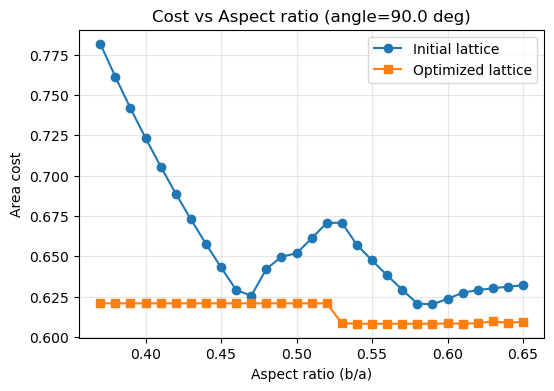

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Cost vs Aspect ratio (angle=90.0 deg)'}, xlabel='Aspect ratio (b/a)', ylabel='Area cost'>)

In [7]:
plot_cost_curves(res1, res2, aspect_ratios, angles, fixed_angle=90.0)

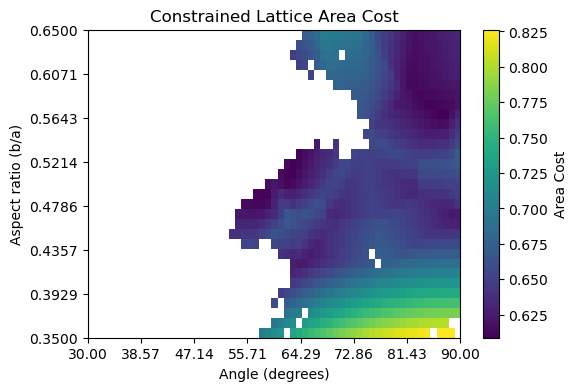

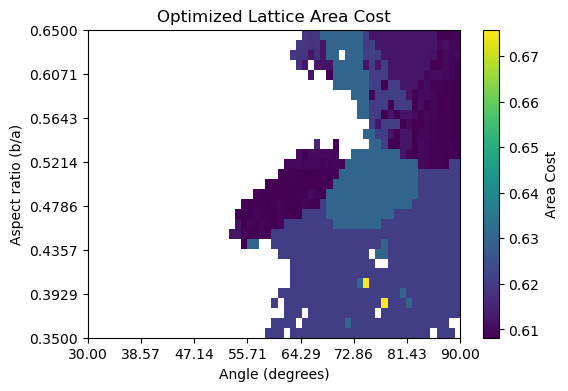

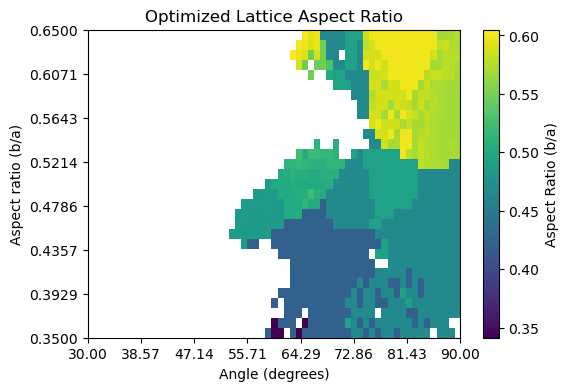

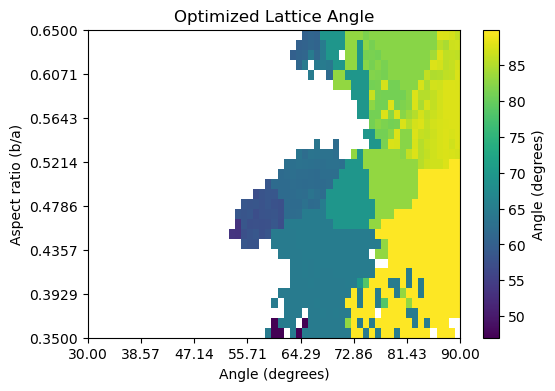

(<Figure size 600x400 with 2 Axes>,
 <Axes: title={'center': 'Optimized Lattice Angle'}, xlabel='Angle (degrees)', ylabel='Aspect ratio (b/a)'>)

In [8]:
plot_heatmaps(res1, aspect_ratios, angles, title="Constrained Lattice Area Cost", cbar_label="Area Cost")
plot_heatmaps(res2, aspect_ratios, angles, title="Optimized Lattice Area Cost", cbar_label="Area Cost")
plot_heatmaps(res_aspect_ratios, aspect_ratios, angles, title="Optimized Lattice Aspect Ratio", cbar_label="Aspect Ratio (b/a)")
plot_heatmaps(90-np.abs(90-res_angles), aspect_ratios, angles, title="Optimized Lattice Angle", cbar_label="Angle (degrees)")

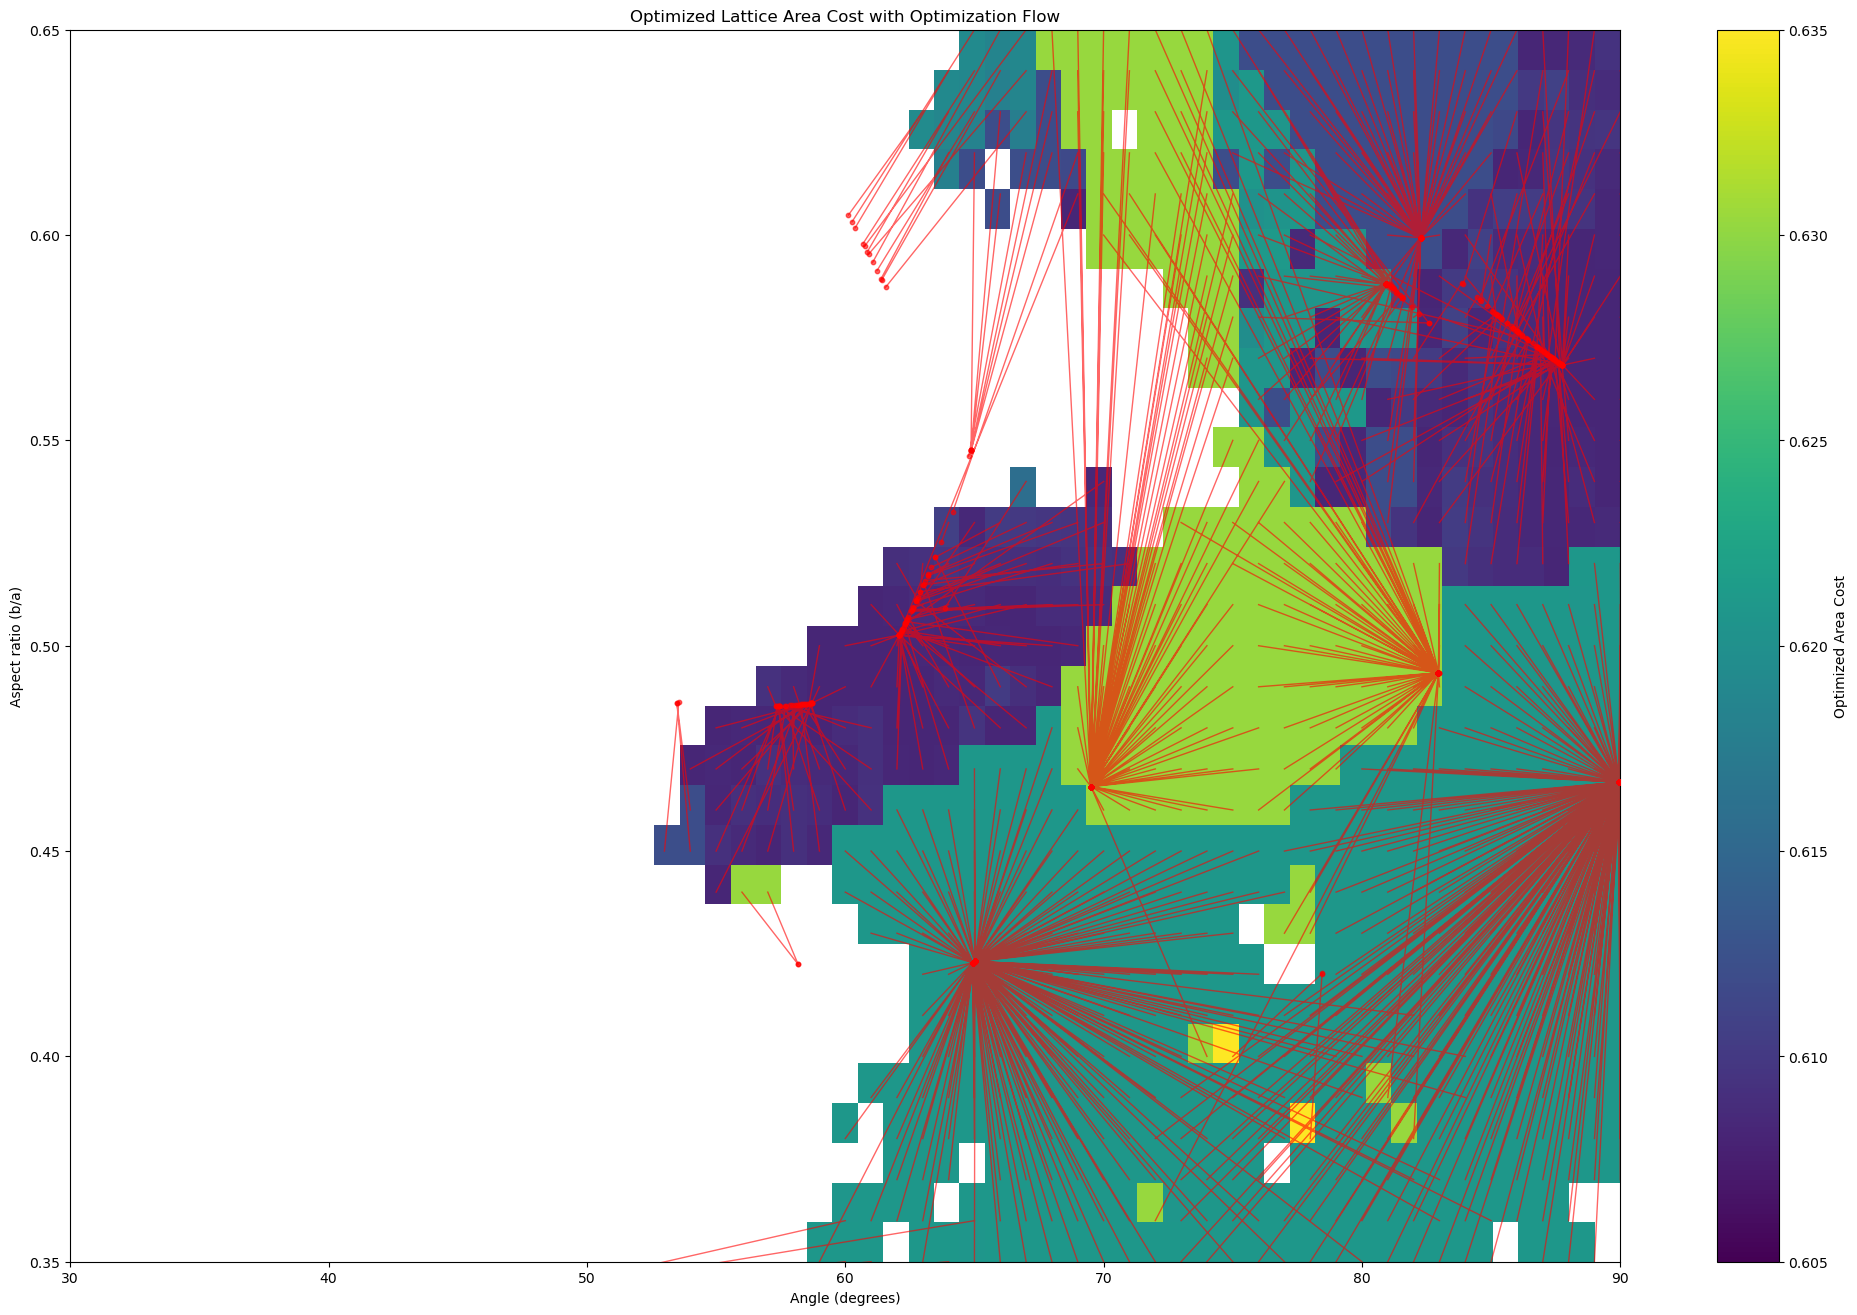

In [9]:
def plot_optimization_flow(res_cost, res_ar_opt, res_ang_opt, aspect_ratios, angles, title="Optimization Flow", clim=None):
    fig, ax = plt.subplots(figsize=(25, 16))
    
    # Plot heatmap
    extent = [angles.min(), angles.max(), aspect_ratios.min(), aspect_ratios.max()]
    im = ax.imshow(res_cost, origin='lower', extent=extent, aspect='auto', cmap='viridis', interpolation='none')
    
    if clim is not None:
        im.set_clim(*clim)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Optimized Area Cost")
    
    # Plot lines with dots at start
    stride_a = 1
    stride_b = 1
    
    lines_x = []
    lines_y = []
    starts_x = []
    starts_y = []
    
    for ia in range(0, len(aspect_ratios), stride_a):
        for ib in range(0, len(angles), stride_b):
            start_ar = aspect_ratios[ia]
            start_ang = angles[ib]
            
            end_ar = res_ar_opt[ia, ib]
            end_ang = res_ang_opt[ia, ib]
            
            if np.isnan(end_ar) or np.isnan(end_ang):
                continue
            
            # Only draw if there is a visible change
            if abs(end_ar - start_ar) < 1e-3 and abs(end_ang - start_ang) < 1e-3:
                continue

            # Collect line segments
            lines_x.extend([start_ang, end_ang, None])
            lines_y.extend([start_ar, end_ar, None])
            
            # Collect start points for dots
            starts_x.append(end_ang)
            starts_y.append(end_ar)

    # Plot all lines at once
    ax.plot(lines_x, lines_y, color="red", lw=1.0, alpha=0.6)
    # Plot all start dots at once
    ax.scatter(starts_x, starts_y, color="red", s=10, alpha=0.6, zorder=3)
                        
    ax.set_xlabel("Angle (degrees)")
    ax.set_ylabel("Aspect ratio (b/a)")
    ax.set_title(title)
    
    ax.set_xlim(angles.min(), angles.max())
    ax.set_ylim(aspect_ratios.min(), aspect_ratios.max())
    
    plt.show()

plot_optimization_flow(res2, res_aspect_ratios, res_angles, aspect_ratios, angles, title="Optimized Lattice Area Cost with Optimization Flow", clim=[0.605, 0.635])

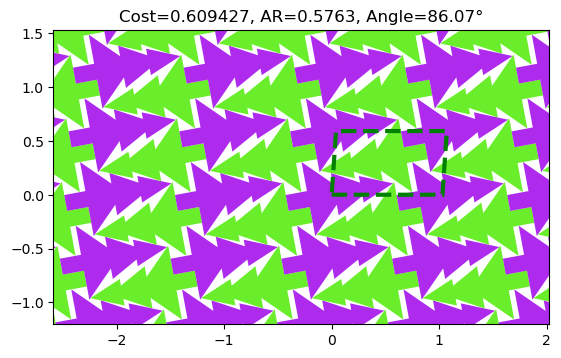

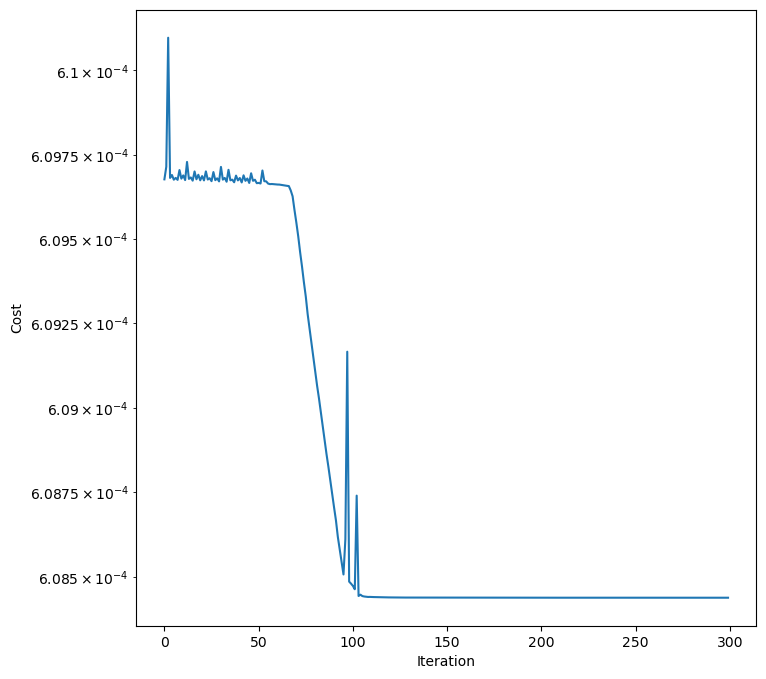

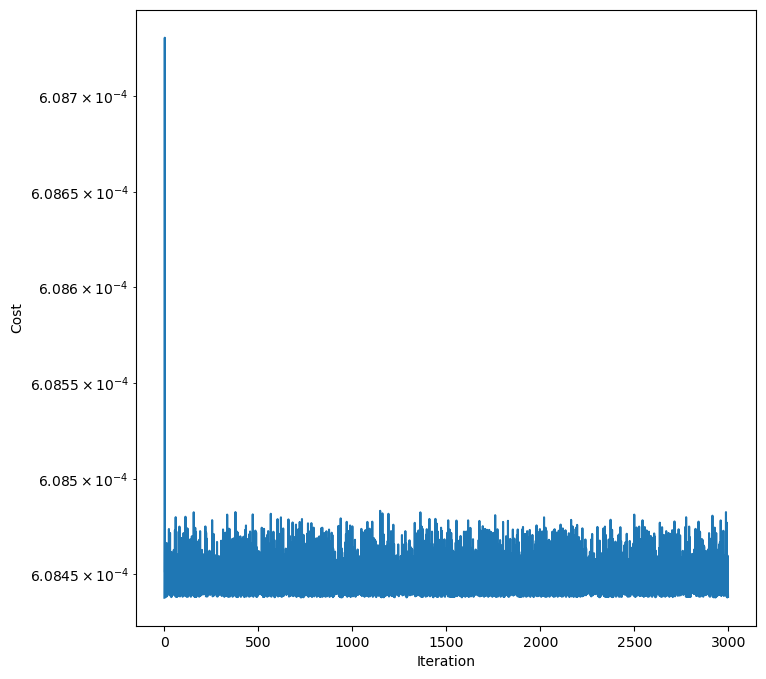

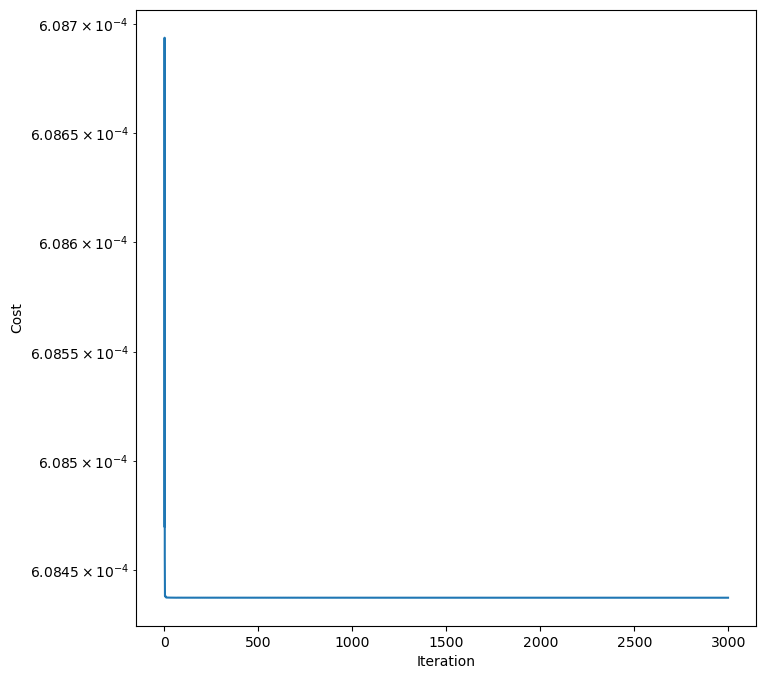

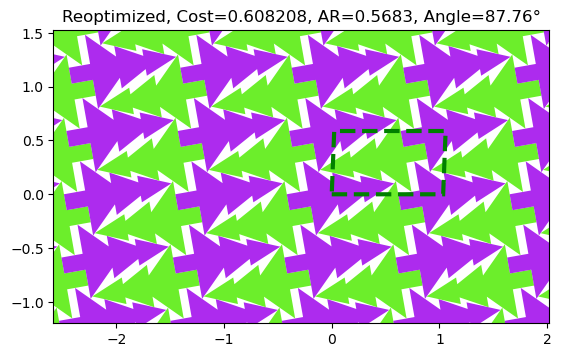

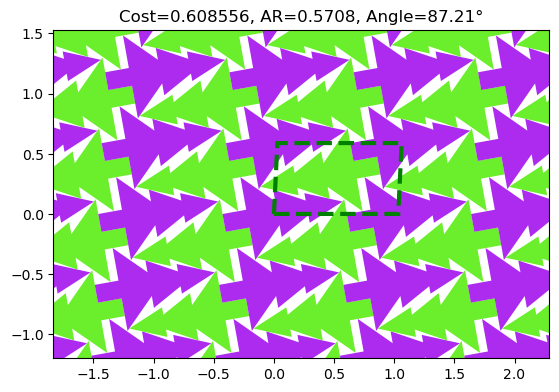

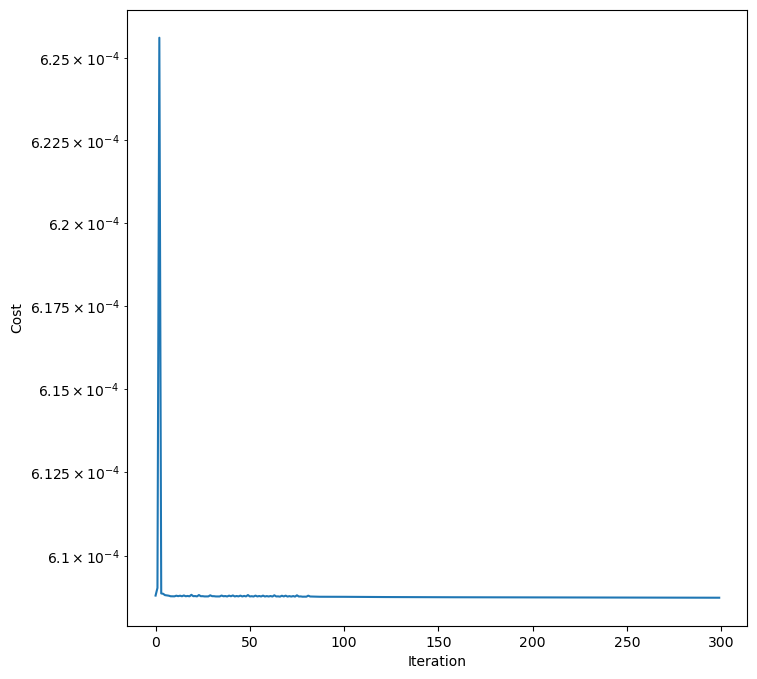

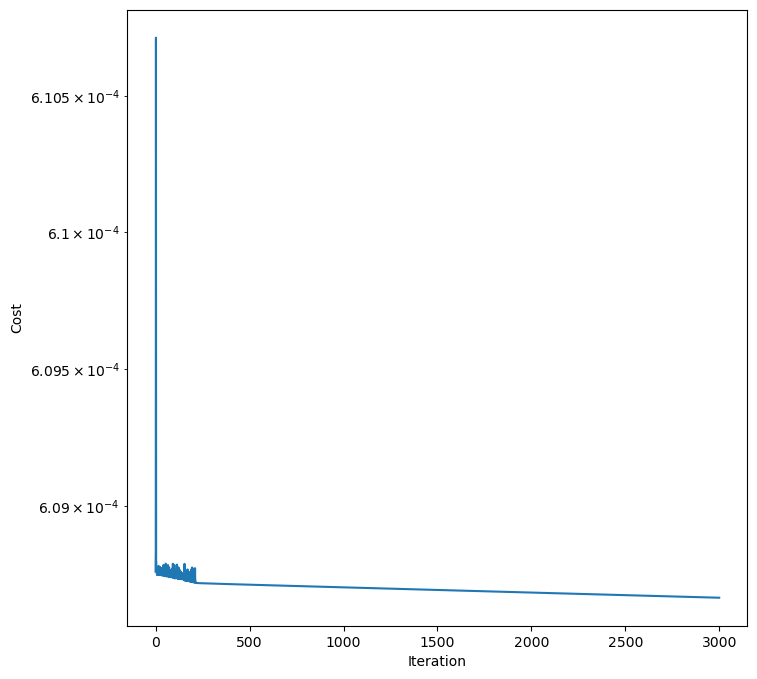

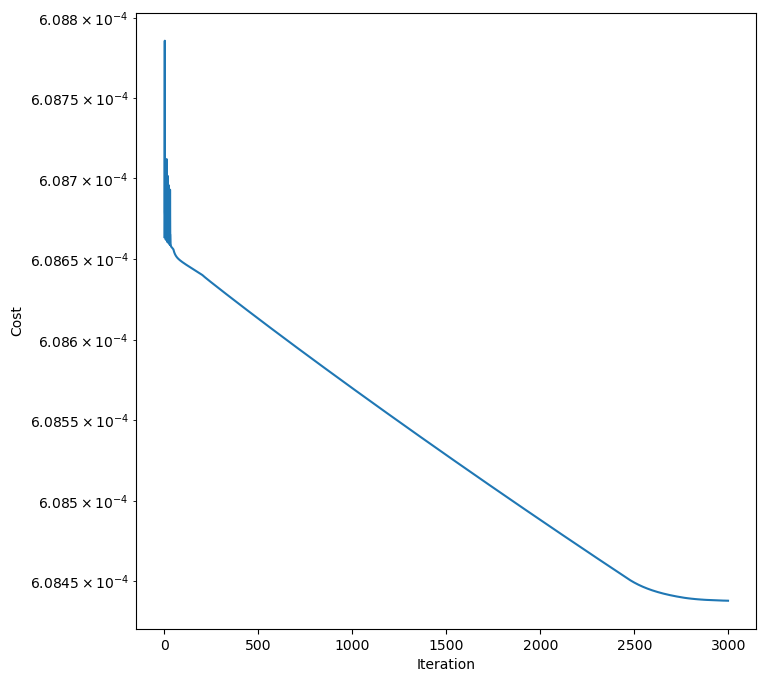

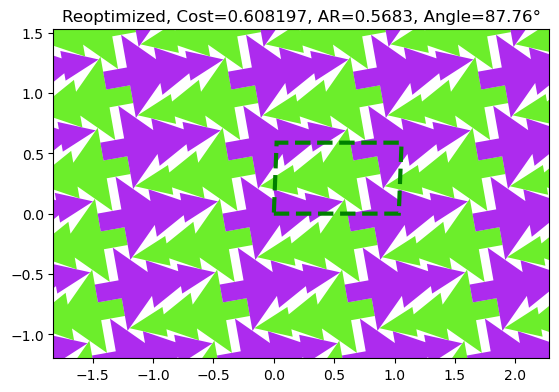

In [17]:
def do_one(ia,ib, ref_h=None):
    sol_opt1 = copy.deepcopy(sol_opt_grid[ia][ib])
    canonicize(sol_opt1)
    pack_vis_sol.pack_vis_sol(sol_opt1)
    # recompute cost, AR, angle in place, using earlier rules
    sol_opt1.N_periodic = 15
    res2[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(sol_opt1)[0][0].get()
    res_angles[ia,ib] = np.degrees(sol_opt1.h[0,2].get())
    res_aspect_ratios[ia,ib] = sol_opt1.h[0,1].get() / sol_opt1.h[0,0].get()

    plt.title(f'Cost={res2[ia][ib]:.6f}, AR={res_aspect_ratios[ia][ib]:.4f}, Angle={res_angles[ia][ib]:.2f}°')
    
    #if not ref_h is None:
    sol_opt1=copy.deepcopy(sol_opt1)
    #sol_opt1.h = copy.deepcopy(ref_h)
    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-3
    #optimizer.dt*=10
    optimizer.n_iterations *= 3
    optimizer.track_cost = True
    optimizer.plot_cost = True
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    solx = optimizer.run_simulation(sol_opt1)
    
    #sol_opt1.h = copy.deepcopy(ref_h)
    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-3/np.sqrt(10)
    #optimizer.dt*=10
    optimizer.n_iterations *= 30
    optimizer.track_cost = True
    optimizer.plot_cost = True
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    solx = optimizer.run_simulation(solx)
    
    #if not ref_h is None:
    #sol_opt1.h = copy.deepcopy(ref_h)
    optimizer = pack_dynamics.OptimizerBFGS()
    optimizer.cost = pack_cost.CostCompound(costs = [pack_cost.AreaCost(scaling=1e-3), 
                            pack_cost.CollisionCostSeparation(scaling=1.)])
    optimizer.max_step = 1e-4
    #optimizer.dt*=10
    optimizer.n_iterations *= 30
    optimizer.track_cost = True
    optimizer.plot_cost = True
    #optimizer.use_line_search = True
    #optimizer.plot_interval = optimizer.dt*10
    solx = optimizer.run_simulation(solx)

    pack_vis_sol.pack_vis_sol(solx)
    # recompute cost, AR, angle in place, using earlier rules
    solx.N_periodic = 15
    res2[ia,ib] = pack_cost.AreaCost().compute_cost_allocate(solx)[0][0].get()
    res_angles[ia,ib] = np.degrees(solx.h[0,2].get())
    res_aspect_ratios[ia,ib] = solx.h[0,1].get() / solx.h[0,0].get()

    plt.title(f'Reoptimized, Cost={res2[ia][ib]:.6f}, AR={res_aspect_ratios[ia][ib]:.4f}, Angle={res_angles[ia][ib]:.2f}°')
do_one(-1,-1, ref_h = sol_opt_grid[-1][-2].h)
do_one(-1,-2, ref_h = sol_opt_grid[-1][-2].h)